In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm


REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [ ]:
print(training_data[1])

[array([[ 62,  89,  73, ...,  52,  49,  51],
       [ 74,  86,  84, ...,  61,  48,  45],
       [101,  91,  80, ...,  41,  52,  63],
       ...,
       [207, 228, 226, ...,  79,  74,  73],
       [216, 212, 176, ...,  78,  83,  81],
       [175, 162, 132, ...,  83,  83,  75]], dtype=uint8)
 array([0., 1.])]


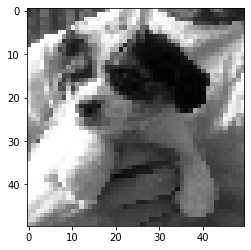

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap= "gray")
plt.show() # gri bir görsel çıkar.

In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/PetImages.zip" -d "/content/Images"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # -1 means any input dimension, 1 means input dimension, 50x50 is shape of input. (((batch_size, size(dim or channel), output_shape)))
        x = torch.randn(50,50).view(-1,1,50,50)

        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #2x2 max pooling output shape
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
      x = F.relu(self.fc1(x))
      x = self.fc2(x) # bc this is our output layer. No activation here.
      return F.softmax(x, dim=1)

net = Net()  

torch.Size([128, 2, 2])


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 # Set pixel values between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

#Datamızı traning ve validation yada testing olarak ayırmamız gerekiyor.
#Datasetimizin yüzde %10'u
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [ ]:
#Bu adımda eğitmeye çalışıyoruz.
#Hafıza hatası alırsanız batch_size'ı küçültün.
BATCH_SIZE = 100

#Şu anlık 1 yapıyoruz ama ilerde bu artmalı.
EPOCHS = 1

for epoch in range(EPOCHS):
  #range(0) yaptık çünkü sıfırda başlamasını istiyoruz.
  #tqdm, progress bar ile bize loading çıktısı gösterir.
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
    #Traning datasetlerin batch'lenmiş çıktılarını verir.
    #print(i, i+BATCH_SIZE)
    batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
    batch_y = train_y[i:i+BATCH_SIZE]

    net.zero_grad()

    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y)
    loss.backward()
    optimizer.step()    # Does the update

  print(f"Epoch: {epoch}. Loss: {loss}")


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:42,  2.17it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:33,  2.38it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:26,  2.56it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:21,  2.70it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:17,  2.83it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:14,  2.91it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:13,  2.97it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:11,  3.01it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:10,  3.03it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:10,  3.03it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:10,  3.04it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:09,  3.05it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:08,  3.08it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:07,  3.09it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:07,  3.09it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:05<01:07,  3.10it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:06,  3.09it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:06,  3.08it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:06<01:05,  3.11it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:06<01:05,  3.11it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:07<01:05,  3.12it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:07<01:04,  3.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:08<01:05,  3.07it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:08<01:04,  3.08it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:08<01:04,  3.09it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:09<01:03,  3.10it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:09<01:03,  3.10it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:09<01:02,  3.11it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:10<01:02,  3.11it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:10<01:02,  3.11it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:10<01:02,  3.09it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:11<01:01,  3.09it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:11<01:00,  3.12it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:11<01:00,  3.12it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:12<01:00,  3.13it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:12<00:59,  3.15it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:12<00:58,  3.16it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:13<00:58,  3.15it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:13<00:58,  3.15it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:13<00:57,  3.16it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:14<00:57,  3.16it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:14<00:57,  3.16it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:14<00:56,  3.18it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:14<00:56,  3.16it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:15<00:56,  3.14it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:15<00:56,  3.16it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:15<00:55,  3.17it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:16<00:55,  3.16it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:16<00:55,  3.16it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:16<00:54,  3.16it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:17<00:54,  3.16it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:17<00:54,  3.16it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:17<00:53,  3.17it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:18<00:53,  3.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:18<00:53,  3.13it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:19<00:53,  3.13it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:19<00:52,  3.15it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:19<00:51,  3.16it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:20<00:51,  3.18it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:20<00:51,  3.17it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:20<00:50,  3.17it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:20<00:50,  3.19it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:21<00:50,  3.17it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:21<00:49,  3.18it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:21<00:49,  3.16it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:22<00:49,  3.15it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:22<00:48,  3.17it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:22<00:48,  3.18it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:23<00:48,  3.16it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:23<00:48,  3.15it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:23<00:47,  3.16it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:24<00:47,  3.15it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:24<00:47,  3.15it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:24<00:46,  3.18it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:25<00:46,  3.16it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:25<00:46,  3.15it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:25<00:45,  3.17it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:26<00:45,  3.16it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:26<00:45,  3.16it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:26<00:44,  3.17it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:26<00:44,  3.16it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:27<00:44,  3.14it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:27<00:43,  3.16it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:27<00:43,  3.16it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:28<00:43,  3.12it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:28<00:43,  3.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:29<00:43,  3.11it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:29<00:42,  3.13it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:29<00:41,  3.15it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:30<00:41,  3.16it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:30<00:41,  3.14it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:30<00:40,  3.17it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:31<00:40,  3.16it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:31<00:40,  3.15it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:31<00:39,  3.19it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:32<00:39,  3.20it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:32<00:38,  3.19it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:32<00:38,  3.21it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:33<00:37,  3.21it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:33<00:37,  3.19it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:33<00:37,  3.18it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:33<00:37,  3.19it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:34<00:37,  3.18it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:34<00:37,  3.15it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:34<00:36,  3.17it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:35<00:36,  3.16it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:35<00:36,  3.16it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:35<00:35,  3.18it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:36<00:35,  3.18it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:36<00:35,  3.12it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:36<00:34,  3.16it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:37<00:34,  3.18it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:37<00:34,  3.16it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:37<00:33,  3.17it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:38<00:33,  3.19it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:38<00:32,  3.20it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:38<00:32,  3.18it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:38<00:32,  3.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:39<00:32,  3.12it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:39<00:31,  3.15it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:40<00:31,  3.17it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:40<00:30,  3.16it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:40<00:30,  3.15it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:41<00:30,  3.16it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:41<00:30,  3.16it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:41<00:29,  3.18it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:42<00:29,  3.19it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:42<00:28,  3.20it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:42<00:28,  3.20it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:43<00:28,  3.20it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:43<00:27,  3.21it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:43<00:27,  3.17it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:44<00:27,  3.16it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:44<00:27,  3.18it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:44<00:26,  3.18it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:44<00:26,  3.19it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:45<00:26,  3.19it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:45<00:25,  3.18it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:45<00:25,  3.19it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:46<00:25,  3.18it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:46<00:24,  3.17it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:46<00:24,  3.17it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:47<00:24,  3.18it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:47<00:23,  3.19it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:47<00:23,  3.19it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:48<00:23,  3.20it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:48<00:22,  3.20it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:48<00:22,  3.20it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:49<00:22,  3.20it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:49<00:21,  3.20it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:49<00:21,  3.19it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:50<00:21,  3.15it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:50<00:21,  3.15it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:50<00:20,  3.15it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:50<00:20,  3.17it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:51<00:20,  3.19it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:51<00:19,  3.17it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:51<00:19,  3.19it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:52<00:19,  3.18it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:52<00:18,  3.17it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:52<00:18,  3.17it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:53<00:18,  3.18it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:53<00:17,  3.19it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:53<00:17,  3.18it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:54<00:17,  3.20it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:54<00:16,  3.20it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:54<00:16,  3.19it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:55<00:16,  3.18it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:55<00:15,  3.19it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:55<00:15,  3.20it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:55<00:15,  3.20it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:56<00:14,  3.20it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:56<00:14,  3.22it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:56<00:14,  3.20it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:57<00:14,  3.21it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:57<00:13,  3.18it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:57<00:13,  3.18it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:58<00:13,  3.17it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:58<00:12,  3.18it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:58<00:12,  3.18it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:59<00:12,  3.21it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:59<00:11,  3.21it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:59<00:11,  3.22it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:00<00:11,  3.22it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:00<00:11,  3.15it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:00<00:10,  3.15it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:00<00:10,  3.17it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:01<00:10,  3.20it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:01<00:09,  3.20it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:01<00:09,  3.19it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:02<00:09,  3.21it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:02<00:08,  3.21it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:02<00:08,  3.20it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:03<00:08,  3.21it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:03<00:07,  3.22it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:03<00:07,  3.22it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:04<00:07,  3.23it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:04<00:06,  3.24it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:04<00:06,  3.25it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:05<00:06,  3.24it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:05<00:05,  3.23it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:05<00:05,  3.24it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:05<00:05,  3.22it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:06<00:04,  3.23it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:06<00:04,  3.23it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:06<00:04,  3.22it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:07<00:04,  3.22it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:07<00:03,  3.23it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:07<00:03,  3.23it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:08<00:03,  3.22it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:08<00:02,  3.22it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:08<00:02,  3.22it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:09<00:02,  3.21it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:09<00:01,  3.21it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:09<00:01,  3.22it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:10<00:01,  3.19it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:10<00:00,  3.20it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:10<00:00,  3.18it/s]

torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:10<00:00,  3.17it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:11<00:00,  3.16it/s]

torch.Size([128, 2, 2])
Epoch: 0. Loss: 0.20477412641048431


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

  3%|▎         | 71/2494 [00:00<00:07, 343.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  6%|▌         | 144/2494 [00:00<00:06, 351.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  9%|▊         | 215/2494 [00:00<00:06, 353.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 12%|█▏        | 289/2494 [00:00<00:06, 359.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 14%|█▍        | 358/2494 [00:01<00:06, 344.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 17%|█▋        | 428/2494 [00:01<00:05, 346.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 20%|██        | 501/2494 [00:01<00:05, 354.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 23%|██▎       | 578/2494 [00:01<00:05, 366.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 26%|██▌       | 653/2494 [00:01<00:04, 370.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 29%|██▉       | 728/2494 [00:02<00:04, 358.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 32%|███▏      | 802/2494 [00:02<00:04, 361.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 35%|███▌      | 877/2494 [00:02<00:04, 360.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 38%|███▊      | 953/2494 [00:02<00:04, 367.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 41%|████      | 1028/2494 [00:02<00:04, 364.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 44%|████▍     | 1102/2494 [00:03<00:03, 359.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 47%|████▋     | 1175/2494 [00:03<00:03, 357.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 50%|█████     | 1249/2494 [00:03<00:03, 363.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 53%|█████▎    | 1325/2494 [00:03<00:03, 366.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 56%|█████▌    | 1399/2494 [00:03<00:02, 366.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 59%|█████▉    | 1472/2494 [00:04<00:03, 328.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 62%|██████▏   | 1542/2494 [00:04<00:02, 337.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 65%|██████▍   | 1612/2494 [00:04<00:02, 341.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 68%|██████▊   | 1686/2494 [00:04<00:02, 352.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 71%|███████   | 1760/2494 [00:04<00:02, 357.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 74%|███████▎  | 1834/2494 [00:05<00:01, 360.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 77%|███████▋  | 1909/2494 [00:05<00:01, 361.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 80%|███████▉  | 1983/2494 [00:05<00:01, 362.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 83%|████████▎ | 2059/2494 [00:05<00:01, 367.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 86%|████████▌ | 2133/2494 [00:05<00:00, 363.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 88%|████████▊ | 2207/2494 [00:06<00:00, 359.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 91%|█████████▏| 2280/2494 [00:06<00:00, 359.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 94%|█████████▍| 2354/2494 [00:06<00:00, 353.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 97%|█████████▋| 2429/2494 [00:06<00:00, 361.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:06<00:00, 357.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,